In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

In [77]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
X = MinMaxScaler().fit_transform( df[numerical_attr_list])
y = OneHotEncoder().fit_transform(df["actor"].values.reshape(-1,1)).toarray()

In [78]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Flatten, concatenate, BatchNormalization
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu", name="dense_a")(input)
dense = Dense(256, activation="relu", name="dense_b")(dense)
dense = Dense(256, activation="relu", name="dense_c")(dense)
dense = Dense(256, activation="relu", name="dense_d")(dense)

# Now adds an output layer
# This will be removed when used in LstmEncoder
enc = Dense(y.shape[1], activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=enc, name="DenseNetwork")
model.compile(optimizer="adam",
            loss="categorical_crossentropy",
            metrics= [CategoricalCrossentropy()],)
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 251)]             0         
                                                                 
 dense_a (Dense)             (None, 256)               64512     
                                                                 
 dense_b (Dense)             (None, 256)               65792     
                                                                 
 dense_c (Dense)             (None, 256)               65792     
                                                                 
 dense_d (Dense)             (None, 256)               65792     
                                                                 
 output (Dense)              (None, 24)                6168      
                                                                 
Total params: 268,056
Trainable params: 268,056
Non-tr

In [79]:
history = model.fit(X, y, epochs=30, batch_size=10, verbose=0)

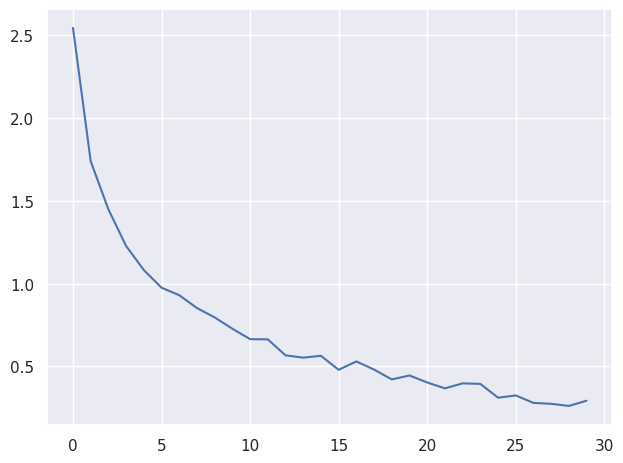

In [80]:
plt.plot(history.history["loss"])

1/1 [==============================] - 0s 62ms/step


/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


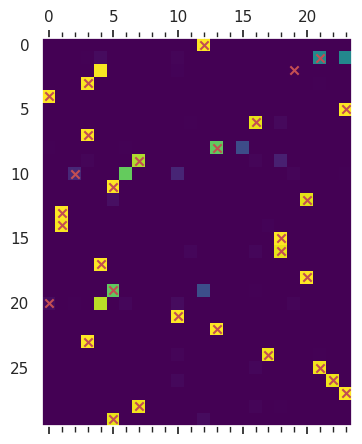

In [84]:
who = np.random.randint(len(df),size=30)

plt.matshow(model.predict(X[who,:]), cmap = "viridis")
plt.scatter( np.argmax(y[who], axis=-1), np.arange(30), marker="x", color="r")
plt.grid("")

## Unbalanced

In [125]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Flatten, concatenate, BatchNormalization
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu", name="dense_a")(input)
dense = Dense(256, activation="relu", name="dense_b")(dense)
dense = Dense(256, activation="relu", name="dense_c")(dense)
dense = Dense(256, activation="relu", name="dense_d")(dense)

# Now adds an output layer
# This will be removed when used in LstmEncoder
enc = Dense(1, activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=enc, name="DenseNetwork")
model.compile(optimizer="adam",
            loss="binary_crossentropy",
            metrics= [BinaryCrossentropy()],)
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 251)]             0         
                                                                 
 dense_a (Dense)             (None, 256)               64512     
                                                                 
 dense_b (Dense)             (None, 256)               65792     
                                                                 
 dense_c (Dense)             (None, 256)               65792     
                                                                 
 dense_d (Dense)             (None, 256)               65792     
                                                                 
 output (Dense)              (None, 1)                 257       
                                                                 
Total params: 262,145
Trainable params: 262,145
Non-tr

In [126]:
X = MinMaxScaler().fit_transform(df[(df["actor"] == "actor_1")|(df["actor"] == "actor_2")][numerical_attr_list].values)
y = (df[(df["actor"] == "actor_1")|(df["actor"] == "actor_2")]["actor"] == "actor_1").values.astype(int).reshape(-1,1)

In [127]:
history = model.fit(X, y, epochs=10, batch_size=20)

Epoch 1/10
11/11 [==============================] - 2s 8ms/step - loss: 0.5020 - binary_crossentropy: 0.5020
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0983 - binary_crossentropy: 0.0983
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0580 - binary_crossentropy: 0.0580
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.1854 - binary_crossentropy: 0.1854
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.1548 - binary_crossentropy: 0.1548
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0369 - binary_crossentropy: 0.0369
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0072 - binary_crossentropy: 0.0072
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0056 - binary_crossentropy: 0.0056
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 8.7279e-04 - binary_crossentropy: 8.7279e-04
Epoch 

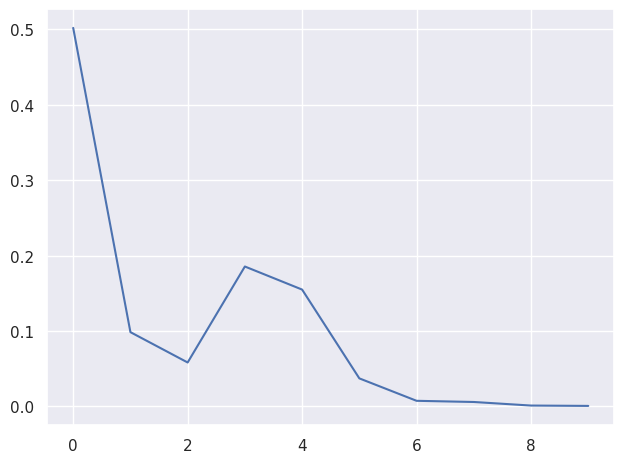

In [128]:
plt.plot(history.history["loss"])

In [130]:
who = np.random.randint(len(X),size=30)

print(model.predict(X[who]).reshape(-1))
print(y[who].reshape(-1))

1/1 [==============================] - 0s 38ms/step
[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.        ]
[0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1]
